In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

sns.set_style("whitegrid")

In [3]:
df_cnn = pd.read_csv("../data/out/generalization/eiytli6p.csv")
df_cnn.head()

,simulation_idx,step_idx,mse,cardinality_target,cardinality_output,cardinality_truth,ospa_kmeans,scale
0,0,0,0.000030,10.995141,10.948864,11,210.898494,1
1,0,1,0.000033,11.958359,11.893385,12,155.911016,1
2,0,2,0.000030,10.786115,11.200277,11,173.531921,1
3,0,3,0.000029,9.902283,10.749969,10,155.008067,1
4,0,4,0.000030,10.786720,10.495864,11,201.557023,1


In [4]:
df_cnn.groupby("scale").mean()

,simulation_idx,step_idx,mse,cardinality_target,cardinality_output,cardinality_truth,ospa_kmeans
scale,,,,,,,
1,49.5,49.5,0.000073,9.756213,19.561915,9.8452,294.582333
2,49.5,49.5,0.000013,10.014710,40.195356,39.9272,203.796026
3,49.5,49.5,0.000015,10.107921,91.592891,90.2938,215.911541
4,49.5,49.5,0.000017,10.109635,163.004613,160.2235,231.331729
5,49.5,49.5,0.000017,10.130919,257.199841,250.5635,246.327892


/tmp/ipykernel_145049/1376558339.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  data = df_cnn.groupby(by=["scale", "simulation_idx"]).mean().drop(columns=["step_idx"]).reset_index()


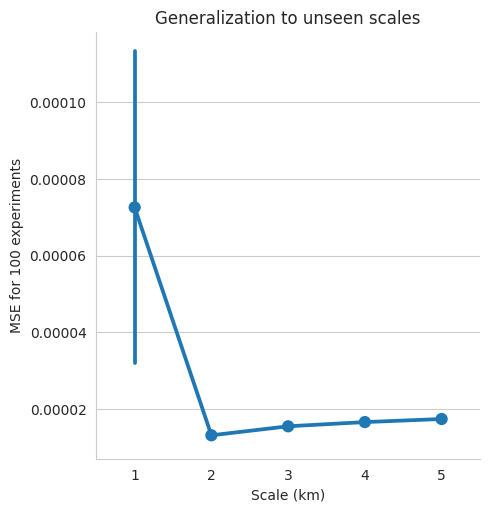

In [12]:
data = df_cnn.groupby(by=["scale", "simulation_idx"]).mean().drop(columns=["step_idx"]).reset_index()
sns.catplot(data=data, x="scale", y="mse", kind="point", errorbar=("sd", 1))
plt.ylabel("MSE for 100 experiments")
plt.xlabel("Scale (km)")
plt.title("Generalization to unseen scales")
plt.show()

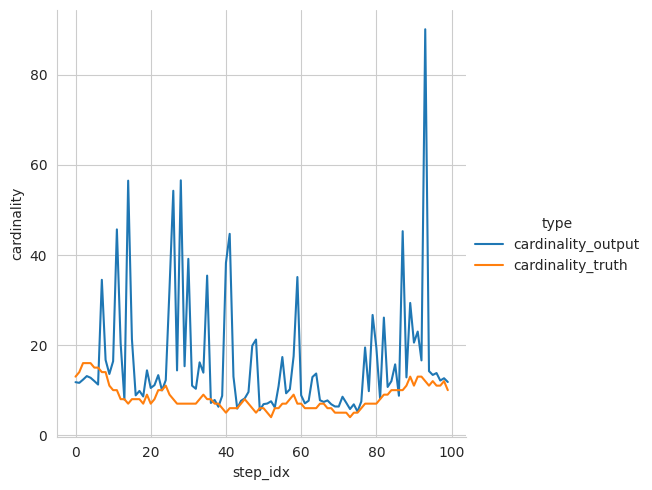

In [25]:
data = df_cnn.query("scale == 1 and simulation_idx == 50").melt(id_vars=["step_idx"], value_vars=["cardinality_output", "cardinality_truth"], var_name="type", value_name="cardinality")
sns.relplot(data=data, x="step_idx", y="cardinality", hue="type", kind="line")

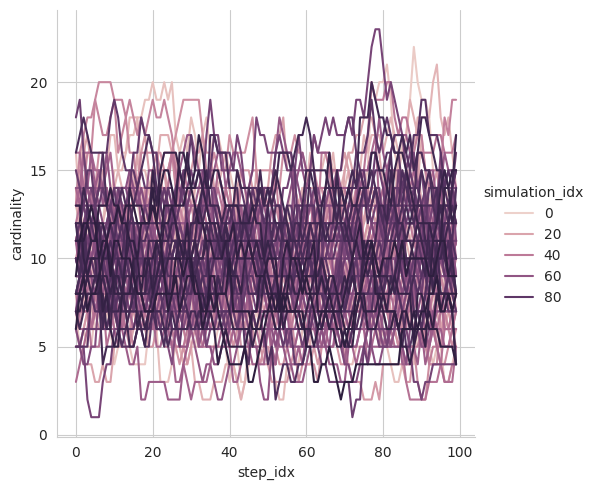

In [15]:
data = df_cnn.query("scale == 1").melt(id_vars=["step_idx", "simulation_idx"], value_vars=["cardinality_truth"], var_name="type", value_name="cardinality")
sns.relplot(data=data, x="step_idx", y="cardinality", hue="simulation_idx", kind="line")

In [8]:
# parse LMCO csv files
lmco_dir = Path("../data/out/filters/")
dfs = []
for dir in lmco_dir.iterdir():
    filter, scale = dir.name.split("_")
    scale = int(float(scale[:-1]))
    df_filter = pd.concat(
        (pd.read_csv(dir / "card_error_mc.csv"), pd.read_csv(dir / "ospa_mc.csv")),
        axis=1
    ).rename(columns={"total": "ospa", "location": "ospa_location", "card": "ospa_card"})
    df_filter["step_idx"] = df_filter["time"].astype(int)
    df_filter["filter"] = filter
    df_filter["scale"] = scale
    dfs.append(df_filter)
df_filters = pd.concat(dfs, axis=0)

In [9]:
columns = ["scale", "filter", "step_idx", "ospa", "card_error"]
df_cnn["card_error"] = df_cnn["cardinality_output"] - df_cnn["cardinality_truth"]
df_cnn["ospa"] = df_cnn["ospa_kmeans"]
df_cnn["filter"] = "cnn"
df_filters = pd.concat(
    (
        df_filters[columns], 
        df_cnn.groupby(["scale", "step_idx", "filter"], as_index=False).mean()[columns]
    ),
)

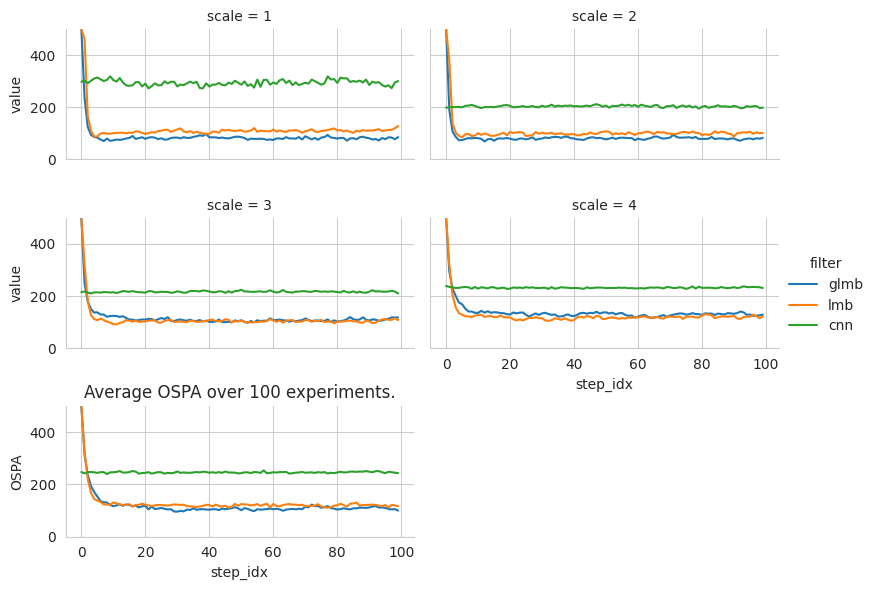

In [10]:
# plot ospa using sns.relplot each row is a different scale
data = df_filters.melt(id_vars=["step_idx", "filter", "scale"], value_vars=["ospa"])
sns.relplot(data=data, x="step_idx", y="value", hue="filter", col="scale", col_wrap=2, kind="line", aspect=2, height=2)
plt.ylabel("OSPA")
plt.ylim(0, 500)
plt.title("Average OSPA over 100 experiments.")
plt.show()